# Model training.

[Dataset](https://www.kaggle.com/datasets/newslab/cholecseg8k?resource=download)


In [1]:
import os

os.environ["CUBLAS_WORKSPACE_CONFIG"]=":4096:8"

In [2]:
import torch
from glob import glob
import numpy as np
import time
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import cv2
import random
from Uformer import modelIdentityAndAtt
from losses import losses
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torch.optim.lr_scheduler import CosineAnnealingLR

In [3]:
torch.cuda.is_available(), torch.cuda.get_device_name(0)

(True, 'NVIDIA GeForce RTX 2060 SUPER')

In [4]:
SEED = 33
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.use_deterministic_algorithms(True)

In [5]:
# determine the device to be used for training and evaluation
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# determine if we will be pinning memory during data loading
PIN_MEMORY = True if DEVICE == "cuda" else False

NUM_CLASSES = 13
# initialize learning rate, number of epochs to train for, and the
# batch size
INIT_LR = 1e-4
WEIGHT_DECAY = 1e-8
NUM_EPOCHS = 100
BATCH_SIZE = 32
# define the input image dimensions
INPUT_IMAGE_WIDTH = 64
INPUT_IMAGE_HEIGHT = 64

## Data preparation.

In [6]:
IMAGE_DATASET_PATH = glob(f'../../Cholec8k/*/*/*/frame_*_endo.png')
MASK_DATASET_PATH  = glob(f'../../Cholec8k/*/*/*/frame_*_endo_watershed_mask.png')
N = len(IMAGE_DATASET_PATH)
assert len(IMAGE_DATASET_PATH) == len(MASK_DATASET_PATH)

print(f'Number of samples: {str(len(MASK_DATASET_PATH))}')

Number of samples: 8080


In [7]:
# https://gist.github.com/IdeaKing/11cf5e146d23c5bb219ba3508cca89ec
def resize_with_pad(image: np.array, 
                    new_shape, 
                    padding_color = (0, 0, 0)) -> np.array:
    """Maintains aspect ratio and resizes with padding.
    Params:
        image: Image to be resized.
        new_shape: Expected (width, height) of new image.
        padding_color: Tuple in BGR of padding color
    Returns:
        image: Resized image with padding
    """
    original_shape = (image.shape[1], image.shape[0])
    ratio = float(max(new_shape))/max(original_shape)
    new_size = tuple([int(x*ratio) for x in original_shape])
    image = cv2.resize(image, new_size, interpolation=cv2.INTER_NEAREST)
    delta_w = new_shape[0] - new_size[0]
    delta_h = new_shape[1] - new_size[1]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=padding_color)
    return image

In [8]:
def to_categorical(y, num_classes=None, dtype="float32"):
	y = np.array(y, dtype="int")
	input_shape = y.shape

	# Shrink the last dimension if the shape is (..., 1).
	if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:
		input_shape = tuple(input_shape[:-1])

	y = y.reshape(-1)
	if not num_classes:
		num_classes = np.max(y) + 1
	n = y.shape[0]
	categorical = np.zeros((n, num_classes), dtype=dtype)
	categorical[np.arange(n), y] = 1
	output_shape = input_shape + (num_classes,)
	categorical = np.reshape(categorical, output_shape)
	return categorical

labels = [[11],[21],[13],[12],[31],[23],[24],[25],[32],[22],[33],[5]]
def encode_mask(masks_arr, n_classes=NUM_CLASSES, H=INPUT_IMAGE_HEIGHT, W=INPUT_IMAGE_WIDTH, labels_arr=labels):
    y_encoded = np.zeros((H, W, 1), dtype=np.uint8)

    for i, label in enumerate(labels_arr):
        y_encoded[np.all(label == masks_arr, axis=-1)] = i + 1
    
    return to_categorical(y_encoded, num_classes=n_classes)

class SegmentationDataset(Dataset):
	def __init__(self, imagePaths, maskPaths):
		# store the image and mask filepaths, and augmentation
		# transforms
		self.imagePaths = imagePaths
		self.maskPaths = maskPaths

	def __len__(self):
		# return the number of total samples contained in the dataset
		return len(self.imagePaths)
	
	def __getitem__(self, idx):
		# grab the image path from the current index
		imagePath = self.imagePaths[idx]
		# load the image from disk, swap its channels from BGR to RGB,
		# and read the associated mask from disk in grayscale mode
		image = cv2.imread(imagePath)
		image = image[10:-10, 120:-120,:]
		image = resize_with_pad(image, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT))
		image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
		image = image / 255
		image = torch.from_numpy(np.float32(image))
		image = image.permute(2,0,1)

		mask = cv2.imread(self.maskPaths[idx])
		mask = mask[10:-10, 120:-120,:]
		mask = resize_with_pad(mask, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT), (50, 50, 50))
		mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
		mask = np.expand_dims(mask, axis=-1)
		mask = encode_mask(mask)
		mask = torch.from_numpy(np.float32(mask))
		mask = mask.permute(2,0,1)

		assert image.shape == (3, INPUT_IMAGE_HEIGHT, INPUT_IMAGE_WIDTH), f"Bad image shape {image.shape}"
		assert mask.shape == (13, INPUT_IMAGE_HEIGHT, INPUT_IMAGE_WIDTH), f"Bad mask shape {mask.shape}"

		# return a tuple of the image and its mask
		return image, mask

In [9]:
uformer = modelIdentityAndAtt.Uformer(img_size=INPUT_IMAGE_HEIGHT,in_chans=13, embed_dim=16, win_size=8, token_projection='linear', token_mlp='leff',modulator=True)
trainImages, testImages, trainMasks, testMasks = train_test_split(IMAGE_DATASET_PATH, MASK_DATASET_PATH, test_size=0.2, random_state=43)

c:\Users\alexg\miniconda3\envs\pytorch-gpu\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [10]:
# define transformations
from torch.utils.data import DataLoader

# create the train and test datasets
trainDS = SegmentationDataset(imagePaths=trainImages, maskPaths=trainMasks)
testDS = SegmentationDataset(imagePaths=testImages, maskPaths=testMasks)
print(f"[INFO] found {len(trainDS)} examples in the training set...")
print(f"[INFO] found {len(testDS)} examples in the test set...")
# create the training and test data loaders
num_workers = 4
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

trainLoader = DataLoader(
	trainDS, 
	shuffle=True,
	batch_size=BATCH_SIZE, 
	pin_memory=PIN_MEMORY,
    worker_init_fn=seed_worker,
    generator=g
)
testLoader = DataLoader(
	testDS, shuffle=False,
	batch_size=BATCH_SIZE, 
	pin_memory=PIN_MEMORY,
    worker_init_fn=seed_worker,
    generator=g
)

[INFO] found 6464 examples in the training set...
[INFO] found 1616 examples in the test set...


In [11]:
uformer = uformer.to(DEVICE)
softmax = torch.nn.Softmax(1)
# initialize loss function and optimizer
lossFunc = losses.TverskyLoss().cuda()
opt = torch.optim.Adam(uformer.parameters(), lr=INIT_LR, betas=(0.9, 0.999),eps=1e-8, weight_decay=WEIGHT_DECAY)
iouMetric = losses.MeanIoU().cuda()
gdlMetric = losses.DiceCoeficient().cuda()

# calculate steps per epoch for training and test set
trainSteps = len(trainDS) // BATCH_SIZE + 1
testSteps = len(testDS) // BATCH_SIZE + 1

scheduler = CosineAnnealingLR(opt, T_max=trainSteps*NUM_EPOCHS)

# initialize a dictionary to store training history
H = {"train_loss": [], "test_loss": [], "train_IoU": [], "test_IoU": [],"train_DC": [], "test_DC": []}

In [12]:
bestIoU = 0
# loop over epochs
print("[INFO] training the network...")
startTime = time.time()
for e in range(NUM_EPOCHS):
	# torch.cuda.empty_cache()
	# set the model in training mode
	uformer.train()
	# initialize the total training and validation loss
	totalTrainLoss = 0
	totalTestLoss = 0

	totalTrainIoU = 0
	totalTestIoU = 0
	totalTrainDC = 0
	totalTestDC = 0
	# loop over the training set
	for i, (x, y) in enumerate(tqdm(trainLoader)):
		# send the input to the device
		x, y = x.to(DEVICE), y.to(DEVICE)
		# perform a forward pass and calculate the training loss
		pred = uformer(x)
		assert pred.shape == y.shape, f"{pred.shape} != {y.shape}" # B, C, H, W
		pred = softmax(pred)
		loss = lossFunc(pred, y)
		# first, zero out any previously accumulated gradients, then
		# perform backpropagation, and then update model parameters
		opt.zero_grad()
		loss.backward()
		opt.step()
		scheduler.step()
		# add the loss to the total training loss so far
		totalTrainLoss += loss
		totalTrainIoU += iouMetric(pred, y)
		totalTrainDC += gdlMetric(pred, y)
	# switch off autograd
	with torch.no_grad():
		# set the model in evaluation mode
		uformer.eval()
		# loop over the validation set
		for (x, y) in testLoader:
			# send the input to the device
			(x, y) = (x.to(DEVICE), y.to(DEVICE))
			# make the predictions and calculate the validation loss
			pred = uformer(x)
			assert pred.shape == y.shape, f"{pred.shape} != {y.shape}" # B, C, H, W
			pred = softmax(pred)
			totalTestLoss += lossFunc(pred, y)
			totalTestIoU += iouMetric(pred, y)
			totalTestDC += gdlMetric(pred, y)
			
	# calculate the average training and validation loss
	avgTrainLoss = totalTrainLoss / trainSteps
	avgTestLoss = totalTestLoss / testSteps

	avgTrainIoU = totalTrainIoU / trainSteps
	avgTestIoU = totalTestIoU / testSteps
	avgTrainDC = totalTrainDC / trainSteps
	avgTestDC = totalTestDC / testSteps
	# update our training history
	H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
	H["test_loss"].append(avgTestLoss.cpu().detach().numpy())

	H["train_IoU"].append(avgTrainIoU.cpu().detach().numpy())
	H["test_IoU"].append(avgTestIoU.cpu().detach().numpy())
	H["train_DC"].append(avgTrainDC.cpu().detach().numpy())
	H["test_DC"].append(avgTestDC.cpu().detach().numpy())

	# print the model training and validation information
	print("[INFO] EPOCH: {}/{}".format(e + 1, NUM_EPOCHS))
	print(f"Train loss: {avgTrainLoss:.6f}, Test loss: {avgTestLoss:.4f}, " + 
       f"Train IoU: {avgTrainIoU:.4f}, Test IoU: {avgTestIoU:.4f}, Train Dice: {avgTrainDC:.4f}, Test Dice: {avgTestDC:.4f}")
	
	if avgTestIoU > bestIoU:
		bestIoU = avgTestIoU
		torch.save(uformer.state_dict(), '../models/uformeridentityandatt_tversky.pth')
		print('Best IoU improved. Model saved.')
		
# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(endTime - startTime))
print(f'Best IoU is: {bestIoU:.5f}')

[INFO] training the network...


100%|██████████| 202/202 [01:50<00:00,  1.83it/s]


[INFO] EPOCH: 1/100
Train loss: 0.434407, Test loss: 0.2334, Train IoU: 0.4123, Test IoU: 0.6225, Train Dice: 0.5607, Test Dice: 0.7666
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:40<00:00,  2.02it/s]


[INFO] EPOCH: 2/100
Train loss: 0.210499, Test loss: 0.2000, Train IoU: 0.6491, Test IoU: 0.6676, Train Dice: 0.7846, Test Dice: 0.8000
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:40<00:00,  2.01it/s]


[INFO] EPOCH: 3/100
Train loss: 0.175565, Test loss: 0.1429, Train IoU: 0.6983, Test IoU: 0.7507, Train Dice: 0.8195, Test Dice: 0.8571
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:39<00:00,  2.03it/s]


[INFO] EPOCH: 4/100
Train loss: 0.135070, Test loss: 0.1290, Train IoU: 0.7583, Test IoU: 0.7721, Train Dice: 0.8600, Test Dice: 0.8710
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:39<00:00,  2.04it/s]


[INFO] EPOCH: 5/100
Train loss: 0.123613, Test loss: 0.1205, Train IoU: 0.7761, Test IoU: 0.7857, Train Dice: 0.8715, Test Dice: 0.8795
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:39<00:00,  2.04it/s]


[INFO] EPOCH: 6/100
Train loss: 0.112299, Test loss: 0.1078, Train IoU: 0.7942, Test IoU: 0.8061, Train Dice: 0.8828, Test Dice: 0.8922
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:39<00:00,  2.03it/s]


[INFO] EPOCH: 7/100
Train loss: 0.103988, Test loss: 0.1026, Train IoU: 0.8076, Test IoU: 0.8145, Train Dice: 0.8911, Test Dice: 0.8974
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:39<00:00,  2.03it/s]


[INFO] EPOCH: 8/100
Train loss: 0.099745, Test loss: 0.0995, Train IoU: 0.8145, Test IoU: 0.8196, Train Dice: 0.8953, Test Dice: 0.9005
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:39<00:00,  2.03it/s]


[INFO] EPOCH: 9/100
Train loss: 0.096943, Test loss: 0.0968, Train IoU: 0.8191, Test IoU: 0.8241, Train Dice: 0.8981, Test Dice: 0.9032
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:39<00:00,  2.03it/s]


[INFO] EPOCH: 10/100
Train loss: 0.094473, Test loss: 0.0953, Train IoU: 0.8232, Test IoU: 0.8266, Train Dice: 0.9006, Test Dice: 0.9047
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:39<00:00,  2.03it/s]


[INFO] EPOCH: 11/100
Train loss: 0.092661, Test loss: 0.0931, Train IoU: 0.8262, Test IoU: 0.8302, Train Dice: 0.9024, Test Dice: 0.9069
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:39<00:00,  2.03it/s]


[INFO] EPOCH: 12/100
Train loss: 0.091376, Test loss: 0.0924, Train IoU: 0.8283, Test IoU: 0.8314, Train Dice: 0.9037, Test Dice: 0.9076
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:39<00:00,  2.02it/s]


[INFO] EPOCH: 13/100
Train loss: 0.090359, Test loss: 0.0911, Train IoU: 0.8300, Test IoU: 0.8336, Train Dice: 0.9047, Test Dice: 0.9089
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:39<00:00,  2.03it/s]


[INFO] EPOCH: 14/100
Train loss: 0.089226, Test loss: 0.0902, Train IoU: 0.8319, Test IoU: 0.8351, Train Dice: 0.9058, Test Dice: 0.9098
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:39<00:00,  2.02it/s]


[INFO] EPOCH: 15/100
Train loss: 0.088121, Test loss: 0.0894, Train IoU: 0.8337, Test IoU: 0.8364, Train Dice: 0.9070, Test Dice: 0.9106
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:39<00:00,  2.02it/s]


[INFO] EPOCH: 16/100
Train loss: 0.087479, Test loss: 0.0894, Train IoU: 0.8348, Test IoU: 0.8363, Train Dice: 0.9076, Test Dice: 0.9106


100%|██████████| 202/202 [01:40<00:00,  2.01it/s]


[INFO] EPOCH: 17/100
Train loss: 0.086461, Test loss: 0.0881, Train IoU: 0.8365, Test IoU: 0.8387, Train Dice: 0.9086, Test Dice: 0.9119
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:39<00:00,  2.02it/s]


[INFO] EPOCH: 18/100
Train loss: 0.086815, Test loss: 0.0884, Train IoU: 0.8360, Test IoU: 0.8381, Train Dice: 0.9083, Test Dice: 0.9116


100%|██████████| 202/202 [01:39<00:00,  2.02it/s]


[INFO] EPOCH: 19/100
Train loss: 0.085503, Test loss: 0.0872, Train IoU: 0.8381, Test IoU: 0.8401, Train Dice: 0.9096, Test Dice: 0.9128
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:40<00:00,  2.02it/s]


[INFO] EPOCH: 20/100
Train loss: 0.084716, Test loss: 0.0864, Train IoU: 0.8394, Test IoU: 0.8415, Train Dice: 0.9104, Test Dice: 0.9136
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:39<00:00,  2.02it/s]


[INFO] EPOCH: 21/100
Train loss: 0.084200, Test loss: 0.0863, Train IoU: 0.8403, Test IoU: 0.8417, Train Dice: 0.9109, Test Dice: 0.9137
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:39<00:00,  2.02it/s]


[INFO] EPOCH: 22/100
Train loss: 0.083962, Test loss: 0.0858, Train IoU: 0.8407, Test IoU: 0.8425, Train Dice: 0.9111, Test Dice: 0.9142
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:40<00:00,  2.01it/s]


[INFO] EPOCH: 23/100
Train loss: 0.083317, Test loss: 0.0858, Train IoU: 0.8418, Test IoU: 0.8425, Train Dice: 0.9118, Test Dice: 0.9142


100%|██████████| 202/202 [01:39<00:00,  2.02it/s]


[INFO] EPOCH: 24/100
Train loss: 0.082855, Test loss: 0.0844, Train IoU: 0.8426, Test IoU: 0.8449, Train Dice: 0.9122, Test Dice: 0.9156
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:40<00:00,  2.02it/s]


[INFO] EPOCH: 25/100
Train loss: 0.081037, Test loss: 0.0815, Train IoU: 0.8457, Test IoU: 0.8499, Train Dice: 0.9140, Test Dice: 0.9185
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:39<00:00,  2.02it/s]


[INFO] EPOCH: 26/100
Train loss: 0.077308, Test loss: 0.0793, Train IoU: 0.8521, Test IoU: 0.8536, Train Dice: 0.9178, Test Dice: 0.9207
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:39<00:00,  2.02it/s]


[INFO] EPOCH: 27/100
Train loss: 0.075602, Test loss: 0.0787, Train IoU: 0.8551, Test IoU: 0.8547, Train Dice: 0.9195, Test Dice: 0.9213
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:39<00:00,  2.02it/s]


[INFO] EPOCH: 28/100
Train loss: 0.074504, Test loss: 0.0775, Train IoU: 0.8569, Test IoU: 0.8567, Train Dice: 0.9206, Test Dice: 0.9225
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:39<00:00,  2.02it/s]


[INFO] EPOCH: 29/100
Train loss: 0.073134, Test loss: 0.0752, Train IoU: 0.8593, Test IoU: 0.8606, Train Dice: 0.9219, Test Dice: 0.9248
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:40<00:00,  2.02it/s]


[INFO] EPOCH: 30/100
Train loss: 0.068821, Test loss: 0.0647, Train IoU: 0.8668, Test IoU: 0.8789, Train Dice: 0.9263, Test Dice: 0.9353
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:39<00:00,  2.02it/s]


[INFO] EPOCH: 31/100
Train loss: 0.059089, Test loss: 0.0584, Train IoU: 0.8839, Test IoU: 0.8900, Train Dice: 0.9360, Test Dice: 0.9416
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:40<00:00,  2.02it/s]


[INFO] EPOCH: 32/100
Train loss: 0.054982, Test loss: 0.0558, Train IoU: 0.8912, Test IoU: 0.8946, Train Dice: 0.9401, Test Dice: 0.9442
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:40<00:00,  2.02it/s]


[INFO] EPOCH: 33/100
Train loss: 0.053361, Test loss: 0.0544, Train IoU: 0.8941, Test IoU: 0.8971, Train Dice: 0.9417, Test Dice: 0.9456
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:39<00:00,  2.02it/s]


[INFO] EPOCH: 34/100
Train loss: 0.051771, Test loss: 0.0530, Train IoU: 0.8970, Test IoU: 0.8997, Train Dice: 0.9433, Test Dice: 0.9471
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:40<00:00,  2.02it/s]


[INFO] EPOCH: 35/100
Train loss: 0.050786, Test loss: 0.0522, Train IoU: 0.8987, Test IoU: 0.9010, Train Dice: 0.9443, Test Dice: 0.9478
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:40<00:00,  2.02it/s]


[INFO] EPOCH: 36/100
Train loss: 0.049640, Test loss: 0.0511, Train IoU: 0.9008, Test IoU: 0.9031, Train Dice: 0.9454, Test Dice: 0.9489
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:39<00:00,  2.02it/s]


[INFO] EPOCH: 37/100
Train loss: 0.048656, Test loss: 0.0504, Train IoU: 0.9026, Test IoU: 0.9043, Train Dice: 0.9464, Test Dice: 0.9496
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:39<00:00,  2.02it/s]


[INFO] EPOCH: 38/100
Train loss: 0.047718, Test loss: 0.0493, Train IoU: 0.9043, Test IoU: 0.9063, Train Dice: 0.9474, Test Dice: 0.9507
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:39<00:00,  2.02it/s]


[INFO] EPOCH: 39/100
Train loss: 0.046848, Test loss: 0.0487, Train IoU: 0.9059, Test IoU: 0.9074, Train Dice: 0.9482, Test Dice: 0.9513
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:39<00:00,  2.02it/s]


[INFO] EPOCH: 40/100
Train loss: 0.045424, Test loss: 0.0449, Train IoU: 0.9085, Test IoU: 0.9144, Train Dice: 0.9496, Test Dice: 0.9551
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:39<00:00,  2.02it/s]


[INFO] EPOCH: 41/100
Train loss: 0.040448, Test loss: 0.0405, Train IoU: 0.9177, Test IoU: 0.9224, Train Dice: 0.9546, Test Dice: 0.9595
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:39<00:00,  2.02it/s]


[INFO] EPOCH: 42/100
Train loss: 0.037570, Test loss: 0.0396, Train IoU: 0.9230, Test IoU: 0.9241, Train Dice: 0.9575, Test Dice: 0.9604
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:39<00:00,  2.02it/s]


[INFO] EPOCH: 43/100
Train loss: 0.036242, Test loss: 0.0385, Train IoU: 0.9255, Test IoU: 0.9261, Train Dice: 0.9588, Test Dice: 0.9615
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:39<00:00,  2.02it/s]


[INFO] EPOCH: 44/100
Train loss: 0.035315, Test loss: 0.0377, Train IoU: 0.9272, Test IoU: 0.9275, Train Dice: 0.9598, Test Dice: 0.9623
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:39<00:00,  2.02it/s]


[INFO] EPOCH: 45/100
Train loss: 0.034513, Test loss: 0.0372, Train IoU: 0.9287, Test IoU: 0.9285, Train Dice: 0.9606, Test Dice: 0.9628
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:39<00:00,  2.02it/s]


[INFO] EPOCH: 46/100
Train loss: 0.033915, Test loss: 0.0365, Train IoU: 0.9298, Test IoU: 0.9299, Train Dice: 0.9612, Test Dice: 0.9635
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:40<00:00,  2.02it/s]


[INFO] EPOCH: 47/100
Train loss: 0.033544, Test loss: 0.0361, Train IoU: 0.9305, Test IoU: 0.9305, Train Dice: 0.9615, Test Dice: 0.9639
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:39<00:00,  2.02it/s]


[INFO] EPOCH: 48/100
Train loss: 0.032867, Test loss: 0.0358, Train IoU: 0.9318, Test IoU: 0.9311, Train Dice: 0.9622, Test Dice: 0.9642
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:39<00:00,  2.02it/s]


[INFO] EPOCH: 49/100
Train loss: 0.032435, Test loss: 0.0353, Train IoU: 0.9326, Test IoU: 0.9321, Train Dice: 0.9626, Test Dice: 0.9647
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:39<00:00,  2.02it/s]


[INFO] EPOCH: 50/100
Train loss: 0.032059, Test loss: 0.0348, Train IoU: 0.9333, Test IoU: 0.9330, Train Dice: 0.9630, Test Dice: 0.9652
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:39<00:00,  2.02it/s]


[INFO] EPOCH: 51/100
Train loss: 0.031774, Test loss: 0.0350, Train IoU: 0.9338, Test IoU: 0.9326, Train Dice: 0.9633, Test Dice: 0.9650


100%|██████████| 202/202 [01:40<00:00,  2.02it/s]


[INFO] EPOCH: 52/100
Train loss: 0.031332, Test loss: 0.0343, Train IoU: 0.9347, Test IoU: 0.9340, Train Dice: 0.9637, Test Dice: 0.9657
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:39<00:00,  2.02it/s]


[INFO] EPOCH: 53/100
Train loss: 0.030876, Test loss: 0.0339, Train IoU: 0.9355, Test IoU: 0.9346, Train Dice: 0.9642, Test Dice: 0.9661
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:39<00:00,  2.02it/s]


[INFO] EPOCH: 54/100
Train loss: 0.030608, Test loss: 0.0337, Train IoU: 0.9360, Test IoU: 0.9350, Train Dice: 0.9645, Test Dice: 0.9663
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:40<00:00,  2.01it/s]


[INFO] EPOCH: 55/100
Train loss: 0.030304, Test loss: 0.0336, Train IoU: 0.9366, Test IoU: 0.9353, Train Dice: 0.9648, Test Dice: 0.9664
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:39<00:00,  2.02it/s]


[INFO] EPOCH: 56/100
Train loss: 0.030127, Test loss: 0.0334, Train IoU: 0.9369, Test IoU: 0.9356, Train Dice: 0.9649, Test Dice: 0.9666
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:39<00:00,  2.02it/s]


[INFO] EPOCH: 57/100
Train loss: 0.029692, Test loss: 0.0331, Train IoU: 0.9377, Test IoU: 0.9362, Train Dice: 0.9654, Test Dice: 0.9669
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:39<00:00,  2.02it/s]


[INFO] EPOCH: 58/100
Train loss: 0.029651, Test loss: 0.0330, Train IoU: 0.9378, Test IoU: 0.9363, Train Dice: 0.9654, Test Dice: 0.9670
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:39<00:00,  2.02it/s]


[INFO] EPOCH: 59/100
Train loss: 0.029446, Test loss: 0.0329, Train IoU: 0.9382, Test IoU: 0.9366, Train Dice: 0.9656, Test Dice: 0.9671
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:39<00:00,  2.03it/s]


[INFO] EPOCH: 60/100
Train loss: 0.029116, Test loss: 0.0326, Train IoU: 0.9388, Test IoU: 0.9371, Train Dice: 0.9660, Test Dice: 0.9674
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:40<00:00,  2.02it/s]


[INFO] EPOCH: 61/100
Train loss: 0.028950, Test loss: 0.0326, Train IoU: 0.9391, Test IoU: 0.9370, Train Dice: 0.9661, Test Dice: 0.9674


100%|██████████| 202/202 [01:39<00:00,  2.02it/s]


[INFO] EPOCH: 62/100
Train loss: 0.028848, Test loss: 0.0324, Train IoU: 0.9393, Test IoU: 0.9374, Train Dice: 0.9662, Test Dice: 0.9676
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:39<00:00,  2.02it/s]


[INFO] EPOCH: 63/100
Train loss: 0.028590, Test loss: 0.0322, Train IoU: 0.9398, Test IoU: 0.9378, Train Dice: 0.9665, Test Dice: 0.9678
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:40<00:00,  2.02it/s]


[INFO] EPOCH: 64/100
Train loss: 0.028355, Test loss: 0.0322, Train IoU: 0.9402, Test IoU: 0.9379, Train Dice: 0.9667, Test Dice: 0.9678
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:40<00:00,  2.02it/s]


[INFO] EPOCH: 65/100
Train loss: 0.028175, Test loss: 0.0320, Train IoU: 0.9406, Test IoU: 0.9382, Train Dice: 0.9669, Test Dice: 0.9680
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:40<00:00,  2.02it/s]


[INFO] EPOCH: 66/100
Train loss: 0.028074, Test loss: 0.0318, Train IoU: 0.9408, Test IoU: 0.9386, Train Dice: 0.9670, Test Dice: 0.9682
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:40<00:00,  2.02it/s]


[INFO] EPOCH: 67/100
Train loss: 0.027884, Test loss: 0.0317, Train IoU: 0.9411, Test IoU: 0.9387, Train Dice: 0.9672, Test Dice: 0.9683
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:40<00:00,  2.02it/s]


[INFO] EPOCH: 68/100
Train loss: 0.027731, Test loss: 0.0316, Train IoU: 0.9414, Test IoU: 0.9389, Train Dice: 0.9673, Test Dice: 0.9684
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:40<00:00,  2.02it/s]


[INFO] EPOCH: 69/100
Train loss: 0.027615, Test loss: 0.0316, Train IoU: 0.9417, Test IoU: 0.9389, Train Dice: 0.9675, Test Dice: 0.9684
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:40<00:00,  2.02it/s]


[INFO] EPOCH: 70/100
Train loss: 0.027483, Test loss: 0.0314, Train IoU: 0.9419, Test IoU: 0.9392, Train Dice: 0.9676, Test Dice: 0.9686
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:40<00:00,  2.02it/s]


[INFO] EPOCH: 71/100
Train loss: 0.027317, Test loss: 0.0314, Train IoU: 0.9422, Test IoU: 0.9394, Train Dice: 0.9678, Test Dice: 0.9686
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:40<00:00,  2.02it/s]


[INFO] EPOCH: 72/100
Train loss: 0.027180, Test loss: 0.0312, Train IoU: 0.9425, Test IoU: 0.9397, Train Dice: 0.9679, Test Dice: 0.9688
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:40<00:00,  2.01it/s]


[INFO] EPOCH: 73/100
Train loss: 0.027087, Test loss: 0.0312, Train IoU: 0.9427, Test IoU: 0.9397, Train Dice: 0.9680, Test Dice: 0.9688
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:40<00:00,  2.02it/s]


[INFO] EPOCH: 74/100
Train loss: 0.027023, Test loss: 0.0312, Train IoU: 0.9428, Test IoU: 0.9398, Train Dice: 0.9681, Test Dice: 0.9688
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:40<00:00,  2.01it/s]


[INFO] EPOCH: 75/100
Train loss: 0.026847, Test loss: 0.0310, Train IoU: 0.9431, Test IoU: 0.9400, Train Dice: 0.9682, Test Dice: 0.9690
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:40<00:00,  2.01it/s]


[INFO] EPOCH: 76/100
Train loss: 0.026807, Test loss: 0.0310, Train IoU: 0.9432, Test IoU: 0.9402, Train Dice: 0.9683, Test Dice: 0.9690
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:40<00:00,  2.01it/s]


[INFO] EPOCH: 77/100
Train loss: 0.026686, Test loss: 0.0309, Train IoU: 0.9434, Test IoU: 0.9403, Train Dice: 0.9684, Test Dice: 0.9691
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:40<00:00,  2.02it/s]


[INFO] EPOCH: 78/100
Train loss: 0.026561, Test loss: 0.0309, Train IoU: 0.9437, Test IoU: 0.9403, Train Dice: 0.9685, Test Dice: 0.9691
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:40<00:00,  2.02it/s]


[INFO] EPOCH: 79/100
Train loss: 0.026534, Test loss: 0.0309, Train IoU: 0.9437, Test IoU: 0.9403, Train Dice: 0.9685, Test Dice: 0.9691
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:40<00:00,  2.02it/s]


[INFO] EPOCH: 80/100
Train loss: 0.026450, Test loss: 0.0308, Train IoU: 0.9439, Test IoU: 0.9405, Train Dice: 0.9686, Test Dice: 0.9692
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:40<00:00,  2.02it/s]


[INFO] EPOCH: 81/100
Train loss: 0.026330, Test loss: 0.0307, Train IoU: 0.9441, Test IoU: 0.9406, Train Dice: 0.9687, Test Dice: 0.9693
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:40<00:00,  2.02it/s]


[INFO] EPOCH: 82/100
Train loss: 0.026257, Test loss: 0.0307, Train IoU: 0.9443, Test IoU: 0.9406, Train Dice: 0.9688, Test Dice: 0.9693
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:39<00:00,  2.02it/s]


[INFO] EPOCH: 83/100
Train loss: 0.026183, Test loss: 0.0307, Train IoU: 0.9444, Test IoU: 0.9407, Train Dice: 0.9689, Test Dice: 0.9693
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:39<00:00,  2.02it/s]


[INFO] EPOCH: 84/100
Train loss: 0.026141, Test loss: 0.0306, Train IoU: 0.9445, Test IoU: 0.9408, Train Dice: 0.9689, Test Dice: 0.9694
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:39<00:00,  2.02it/s]


[INFO] EPOCH: 85/100
Train loss: 0.026079, Test loss: 0.0306, Train IoU: 0.9446, Test IoU: 0.9409, Train Dice: 0.9690, Test Dice: 0.9694
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:40<00:00,  2.02it/s]


[INFO] EPOCH: 86/100
Train loss: 0.026036, Test loss: 0.0306, Train IoU: 0.9447, Test IoU: 0.9409, Train Dice: 0.9690, Test Dice: 0.9694


100%|██████████| 202/202 [01:39<00:00,  2.02it/s]


[INFO] EPOCH: 87/100
Train loss: 0.025994, Test loss: 0.0305, Train IoU: 0.9448, Test IoU: 0.9410, Train Dice: 0.9691, Test Dice: 0.9695
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:39<00:00,  2.02it/s]


[INFO] EPOCH: 88/100
Train loss: 0.025929, Test loss: 0.0305, Train IoU: 0.9449, Test IoU: 0.9410, Train Dice: 0.9691, Test Dice: 0.9695
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:39<00:00,  2.02it/s]


[INFO] EPOCH: 89/100
Train loss: 0.025926, Test loss: 0.0305, Train IoU: 0.9449, Test IoU: 0.9410, Train Dice: 0.9691, Test Dice: 0.9695
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:39<00:00,  2.02it/s]


[INFO] EPOCH: 90/100
Train loss: 0.025835, Test loss: 0.0305, Train IoU: 0.9451, Test IoU: 0.9411, Train Dice: 0.9692, Test Dice: 0.9695
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:40<00:00,  2.02it/s]


[INFO] EPOCH: 91/100
Train loss: 0.025808, Test loss: 0.0305, Train IoU: 0.9451, Test IoU: 0.9411, Train Dice: 0.9693, Test Dice: 0.9695
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:40<00:00,  2.02it/s]


[INFO] EPOCH: 92/100
Train loss: 0.025774, Test loss: 0.0305, Train IoU: 0.9452, Test IoU: 0.9411, Train Dice: 0.9693, Test Dice: 0.9695
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:40<00:00,  2.02it/s]


[INFO] EPOCH: 93/100
Train loss: 0.025853, Test loss: 0.0305, Train IoU: 0.9451, Test IoU: 0.9411, Train Dice: 0.9692, Test Dice: 0.9695


100%|██████████| 202/202 [01:39<00:00,  2.02it/s]


[INFO] EPOCH: 94/100
Train loss: 0.025784, Test loss: 0.0305, Train IoU: 0.9452, Test IoU: 0.9411, Train Dice: 0.9693, Test Dice: 0.9695
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:40<00:00,  2.02it/s]


[INFO] EPOCH: 95/100
Train loss: 0.025783, Test loss: 0.0304, Train IoU: 0.9452, Test IoU: 0.9412, Train Dice: 0.9693, Test Dice: 0.9696
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:39<00:00,  2.02it/s]


[INFO] EPOCH: 96/100
Train loss: 0.025738, Test loss: 0.0304, Train IoU: 0.9453, Test IoU: 0.9412, Train Dice: 0.9693, Test Dice: 0.9696
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:40<00:00,  2.02it/s]


[INFO] EPOCH: 97/100
Train loss: 0.025744, Test loss: 0.0304, Train IoU: 0.9453, Test IoU: 0.9412, Train Dice: 0.9693, Test Dice: 0.9696
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:40<00:00,  2.02it/s]


[INFO] EPOCH: 98/100
Train loss: 0.025699, Test loss: 0.0304, Train IoU: 0.9454, Test IoU: 0.9412, Train Dice: 0.9694, Test Dice: 0.9696
Best IoU improved. Model saved.


100%|██████████| 202/202 [01:42<00:00,  1.97it/s]


[INFO] EPOCH: 99/100
Train loss: 0.025687, Test loss: 0.0304, Train IoU: 0.9454, Test IoU: 0.9412, Train Dice: 0.9694, Test Dice: 0.9696


100%|██████████| 202/202 [01:40<00:00,  2.02it/s]


[INFO] EPOCH: 100/100
Train loss: 0.025727, Test loss: 0.0304, Train IoU: 0.9453, Test IoU: 0.9412, Train Dice: 0.9693, Test Dice: 0.9696
Best IoU improved. Model saved.
[INFO] total time taken to train the model: 12167.99s
Best IoU is: 0.94120


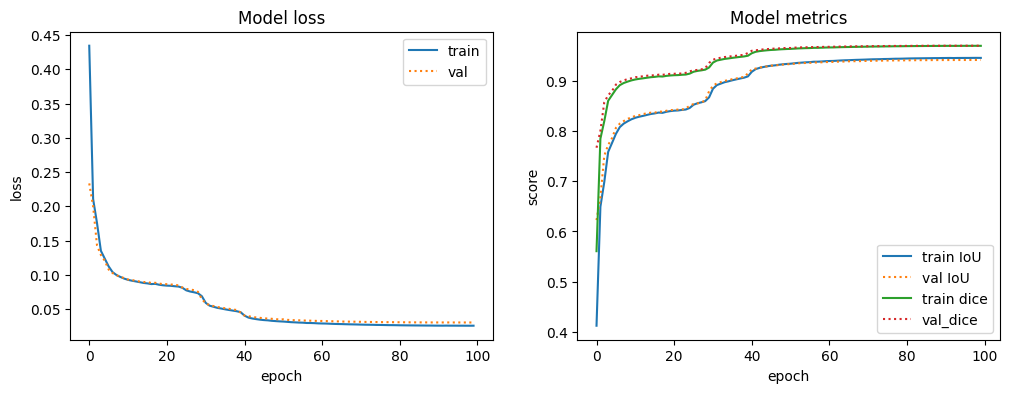

In [13]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(H['train_loss'])
plt.plot(H['test_loss'], linestyle='dotted')
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')

plt.subplot(122)
plt.plot(H['train_IoU'])
plt.plot(H['test_IoU'], linestyle='dotted')
plt.plot(H['train_DC'])
plt.plot(H['test_DC'], linestyle='dotted')
plt.title('Model metrics')
plt.ylabel('score')
plt.xlabel('epoch')

plt.legend(['train IoU', 'val IoU', 'train dice', 'val_dice'], loc='lower right')

plt.show()

In [14]:
def make_prediction(model, image):
	image = torch.Tensor(image).permute((2, 0, 1)).to(DEVICE)
	image = torch.unsqueeze(image, 0)
	# set model to evaluation mode
	model.eval()
	# turn off gradient tracking
	with torch.no_grad():
		predMask = model(image)
		predMask = softmax(predMask)
		predMask = torch.squeeze(predMask, 0)
		predMask = predMask.permute((1, 2, 0))
		predMask = predMask.cpu().detach().numpy()
		predMask = np.argmax(predMask, axis=-1)
		predMask = np.expand_dims(predMask, axis=-1)
		# filter out the weak predictions and convert them to integers
		return predMask.astype(np.uint8)


In [15]:
def getPredImg(image_path):     
    image = cv2.imread(image_path)
    image = image[10:-10, 120:-120,:]
    image = resize_with_pad(image, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image / 255
    return image

def getPredMask(mask_path):
    mask = cv2.imread(mask_path)
    mask = mask[10:-10, 120:-120,:]
    mask = resize_with_pad(mask, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT), (50, 50, 50))
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    mask = np.expand_dims(mask, axis=-1)
    mask = encode_mask(mask)
    return mask

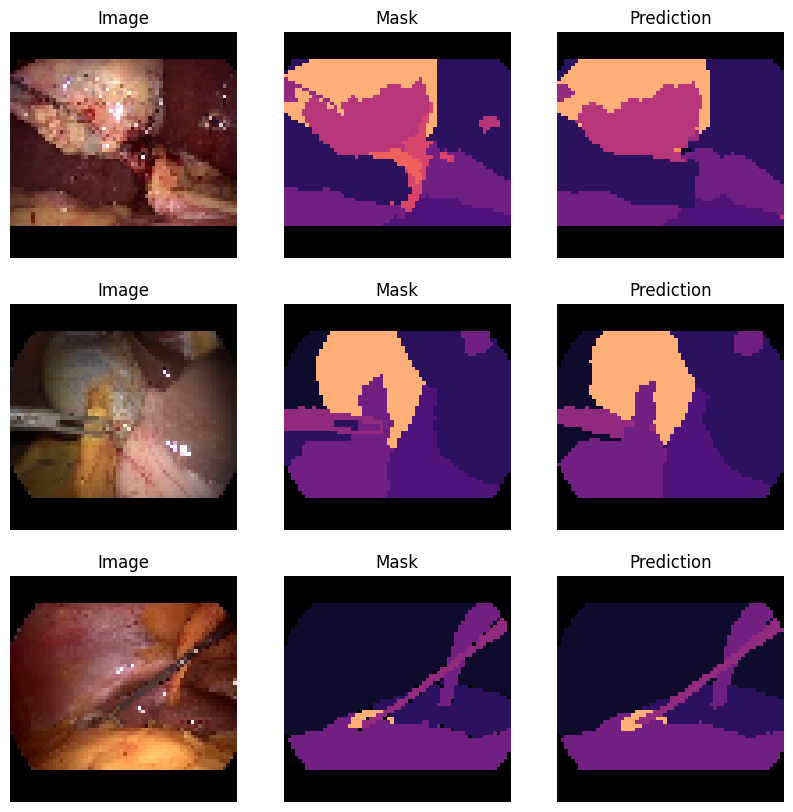

In [16]:
plt.figure(figsize=(10,10))
for i in range(3):    

    idx = random.randint(0, len(testImages) -1)
    img = getPredImg(testImages[idx])
    mask = getPredMask(testMasks[idx])
    
    plt.subplot(331 + 3*i)
    plt.imshow(img)
    plt.title('Image')
    plt.axis("off")

    mask = np.argmax(mask, axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    plt.subplot(332 + 3*i)
    plt.imshow(mask, cmap='magma', norm=plt.Normalize(vmin=0, vmax=12))
    plt.title('Mask')
    plt.axis("off")

    pred = make_prediction(uformer, img)
    plt.subplot(333 + 3*i)
    plt.imshow(pred, cmap='magma', norm=plt.Normalize(vmin=0, vmax=12))
    plt.title('Prediction')
    plt.axis("off")

plt.show()

 --- 
 TFG - Alejandro García Mota